# Mental Health in the Tech

This notebook analyzes the mental health survey results in technology industry. This data comes from Open Source Mental Illness (OSMI) and provides survey data from years 2014, 2016, 2017, 2018 and 2019. The data was collected using open online survey (with the help of Typeform tool), so the sample is not-probability, as no randomization was ensured during its collection. This is important to bear in mind when drawing wider conclusions about the technology sector, let alone the population in general. Sample sizes per year are as follows: 

| Year | n |
|------|------|
| 2014 | 1260 |
| 2016 | 1433 |
| 2017 | 756 |
| 2018 | 417 |
| 2019 | 352 |
|__Total:__| __4218__|

However, different questions were asked each year, and there are only several questions (mostly, demographic ones) that overlap each year:

| Year | Questions n |
|------|------|
| 2014 | 26 |
| 2016 | 60 |
| 2017 | 76 |
| 2018 | 76 |
| 2019 | 76 |

It seems that the latest surveys were the most informative (most questions asked), yet the participation rate is lower. Also, given our task requirements, these 2017-2019 surveys do not cover the question related to diagnosed mental ilnesses which are required for us to answer its prevalence in the population.

### Given these initial observations, we can draft our preliminary plan for data analysis:

__1. Data input and cleaning__
    
Here we have to do some manual work, as not all of the questions are relevant for this research, as its scope is limited. We have manually reviewed the survey questions, and selected the most illustrative ones for our approach – demographics, employment status, workplace culture, personal mental health history. Some of the questions are overly repetitive and nuanced to provide any value for our exploration.

With SQL query, we select UserID (unique identifier), AnswerText (values), QuestionID (primary / foreign key) and QuestionText, also SurveyID which just represents the survey year. Our initial thinking was to limit our analysis with 2016 results, as they're the most robust (given no. of questions, sample, and required questions for the task). However, to see some patterns year-by-year, we decided to maintain data from other years, as well. We used pandas pivot method to transpose the data frame, using UserID and SurveyID as indices, and QuestionID as features.

As QuestionText and QuestionID are both labeling extremes (full question vs. single digit), we manually recoded features to be more convenient to work with.

We removed -1 (no answer) and <18 values from age column (some were also negative); there were very few of them, so it didn't make an impact on the data in general.

We also simplified the gender column, as non-binary options constitute the minority, and are also littered with junk 'joke' answers.

Overall, after the cleaning part, we come up with a dataset with following characteristics:

No. of observations: 4206
No. of features: 43

__2. Socio-demographic description of the dataset__

Using functionalities of pandas and plotting libraries, here we analyze main parameters of the dataset, related to demographic criteria (age, gender, employment, organization type and so forth). We also look for changes over time, where possible. 

The aim of this exercise is to identify possible sampling bias.

__3. Exploratory Data Analysis (EDA)__

In this part, we delve deeper into analysis, looking for patterns beyond workplace culture, personal mental health history, and socio-demographic factors. For this, we'll generally use data from 2016 onwards, as the initial 2014 questionnaire didn't delve into these questions. 

__4. Attempt at inference__

Given the question on diagnosed mental health diseases, we'll try to use inferential statictics methods to draw insights about the population, constructing and plotting confidence intervals.

__5. Summary: key insights and further improvements.__

In [1]:
### Code used to check for count of non-null features across the surveys / year

import pandas as pd
import numpy as np
import sqlite3 as sqlite3

con = sqlite3.connect('dataset/mental_health.sqlite')
cur = con.cursor()

feature_check = pd.read_sql_query("""SELECT COUNT(DISTINCT q.QuestionID) AS non_null_columns_count
                                        FROM Answer a
                                        JOIN Question q ON q.QuestionID = a.QuestionID
                                        JOIN Survey s ON s.SurveyID = a.SurveyID
                                        WHERE s.SurveyID = 2014
                                        AND a.AnswerText IS NOT NULL;
                                  """, con)

print(feature_check)

   non_null_columns_count
0                      26


## 01 Loading the database and data cleaning

In this section, we load the data set using SQLite and doing some preparatory data wrangling:
- pivoting table for analysis;
- simplifying age and gender column values;
- changing column labels.

In [2]:
import pandas as pd
import numpy as np
import sqlite3 as sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

con = sqlite3.connect('dataset/mental_health.sqlite')
cur = con.cursor()

sql = pd.read_sql_query("""SELECT a.UserID, a.SurveyID, q.QuestionID, q.QuestionText, a.AnswerText FROM Answer a 
                        JOIN Question q ON q.QuestionID = a.QuestionID
                        WHERE q.QuestionID IN (1, 2, 3, 4, 5, 50, 51, 89,
                                               54, 55, 79, 80, 92, 93, 113, 117, 118,
                                               6, 7, 20, 21, 30, 31, 32, 33, 34, 48, 49, 78, 115, 116,
                                               8, 9, 13, 68,
                                               10, 14, 18, 19, 85, 114)
                        """, con)
full_df = pd.DataFrame(sql)
con.close()

In [3]:
### Pivoting the dataset

pivot_df = full_df.pivot_table(
    index=['UserID', 'SurveyID'],
    columns='questionid',
    values='AnswerText',
    aggfunc='first'
)
pivot_df.columns.name = None
pivot_df.reset_index(inplace=True)
pivot_df.head()

,UserID,SurveyID,1,2,3,4,5,6,7,8,...,85,89,92,93,113,114,115,116,117,118
0,1,2014,37,Female,United States,Illinois,-1,No,1,6-25,...,NaN,NaN,Often,No,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2014,44,Male,United States,Indiana,-1,No,0,More than 1000,...,NaN,NaN,Rarely,No,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2014,32,Male,Canada,-1,-1,No,0,6-25,...,NaN,NaN,Rarely,No,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2014,31,Male,United Kingdom,-1,-1,Yes,1,26-100,...,NaN,NaN,Often,No,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2014,31,Male,United States,Texas,-1,No,0,100-500,...,NaN,NaN,Never,Yes,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
### Clearing the age column of values <18 and non-provided ones

pivot_df[1] = pivot_df[1].astype('int')
pivot_df[1].dtypes
pivot_df[1].loc[pivot_df[1] < 18]
pivot_df.drop(pivot_df.loc[pivot_df[1] < 18].index, inplace=True)
pivot_df.rename(columns={1: 'age'}, inplace=True)


In [5]:
### Simplifying gender values into three categories

pivot_df.loc[~pivot_df[2].isin(['Female','Male']), 2] = 'Other'
pivot_df[2].value_counts()
pivot_df.rename(columns={2: 'gender'}, inplace=True)

In [6]:
### Changing column labels

rename_cols = {
    'SurveyID': 'year',
    1: 'age',
    2: 'gender',
    3: 'country',
    4: 'US_territory',
    5: 'is_self_employed',
    50: 'work_country',
    51: 'work_US_state',
    89: 'race',
    54: 'productivity_affected',
    55: 'percentage_prod_affected',
    79: 'was_career_affected',
    80: 'how_career_affected',
    92: 'interferes_with_work',
    93: 'remote_50_percent',
    113: 'would_hurt_career',
    117: 'work_position',
    118: 'works_remotely',
    6: 'if_family_mental_disorder',
    7: 'sought_treatment',
    20: 'if_has_medical_cov',
    21: 'knows_resources',
    30: 'willing_to_share_close',
    31: 'less_likely_to_share_obs_of_others',
    32: 'had_mental_d_in_past',
    33: 'has_mental_d_currently',
    34: 'has_been_diagnosed',
    48: 'how_often_interferes_work_treated',
    49: 'how_ofter_interferes_untreated',
    78: 'openly_identified',
    115: 'conditions_diagnosed_with',
    116: 'conditions_believes_has',
    8: 'org_size',
    9: 'employer_is_tech',
    13: 'role_primary_tech',
    68: 'org_primary_tech', # remove
    10: 'employer_benefits_provided',
    14: 'knowledge_of_benefits_available',
    18: 'comfortable_discuss_coworkers',
    19: 'comfortable_dicuss_supervisor',
    85: 'thinks_tech_supports_employees',
    114: 'coworkers_would_view_negative',
}
pivot_df.rename(columns=rename_cols, inplace=True)


In [7]:
pivot_df.head()

,UserID,year,age,gender,country,US_territory,is_self_employed,if_family_mental_disorder,sought_treatment,org_size,...,thinks_tech_supports_employees,race,interferes_with_work,remote_50_percent,would_hurt_career,coworkers_would_view_negative,conditions_diagnosed_with,conditions_believes_has,work_position,works_remotely
0,1,2014,37,Female,United States,Illinois,-1,No,1,6-25,...,NaN,NaN,Often,No,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2014,44,Male,United States,Indiana,-1,No,0,More than 1000,...,NaN,NaN,Rarely,No,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2014,32,Male,Canada,-1,-1,No,0,6-25,...,NaN,NaN,Rarely,No,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2014,31,Male,United Kingdom,-1,-1,Yes,1,26-100,...,NaN,NaN,Often,No,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2014,31,Male,United States,Texas,-1,No,0,100-500,...,NaN,NaN,Never,Yes,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# sample comparison by year

sample_comparison = pd.DataFrame(
    {
        '2014': pivot_df.loc[pivot_df['year'] == 2014].count(axis=0),
        '2016': pivot_df.loc[pivot_df['year'] == 2016].count(axis=0),
        '2017': pivot_df.loc[pivot_df['year'] == 2017].count(axis=0),
        '2018': pivot_df.loc[pivot_df['year'] == 2018].count(axis=0),
        '2019': pivot_df.loc[pivot_df['year'] == 2019].count(axis=0)
    }

)
sample_comparison



,2014,2016,2017,2018,2019
UserID,1253,1430,754,417,351
year,1253,1430,754,417,351
age,1253,1430,754,417,351
gender,1253,1430,754,417,351
country,1253,1430,754,417,351
US_territory,1253,1430,754,417,351
is_self_employed,1253,1430,754,417,351
if_family_mental_disorder,1253,1430,754,417,351
sought_treatment,1253,1430,754,417,351
org_size,1253,1430,754,417,351


### Overview

We have the final dataset for further analysis, comprising:
- 4205 observations;
- 43 columns;
- Three int64 datatype features (UserID, year, age);
- All other features are object data type.

We will leave this data frame as it is for now, and will return to some data wrangling if our EDA will require us to.

## 02 Sociodemographics of the dataset

In the following cells, we'll provide the general overview of the data in terms of its social and demographic characteristics. Those are:

- age,
- gender,
- race [1],
- countries and territories,
- work countries and territories [2],
- employment status and workplace characteristics.



[1] _Race question was only covered in 2017-2019 surveys_

[2] _Work country question wasn't covered in 2014 survey_


In [10]:
sns.set_palette("Set2")

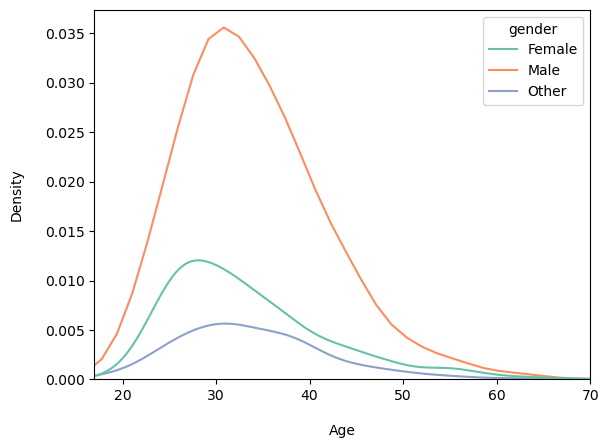

In [61]:
fig, ax = plt.subplots()
sns.kdeplot(data=pivot_df, x='age', ax=ax, hue='gender')
ax.set_xlim(17, 70)
ax.set_xlabel('Age', labelpad=15)
ax.set_ylabel('Density', labelpad=15);

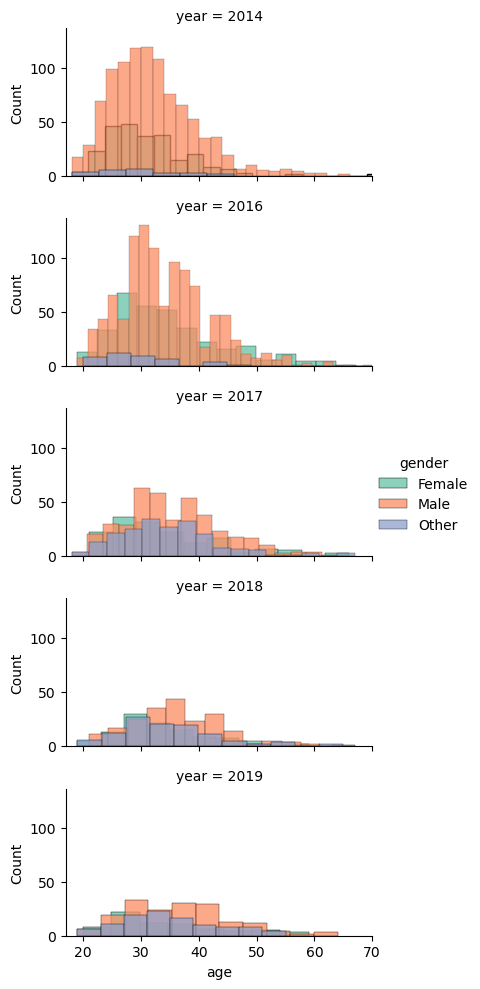

In [62]:
ordered_years = pivot_df.year.unique()
g = sns.FacetGrid(pivot_df, row="year", row_order=ordered_years,
                  height=2, aspect=2, hue='gender')
g.map(sns.histplot, 'age')
g.set(xlim=(17, 70))
g.add_legend();

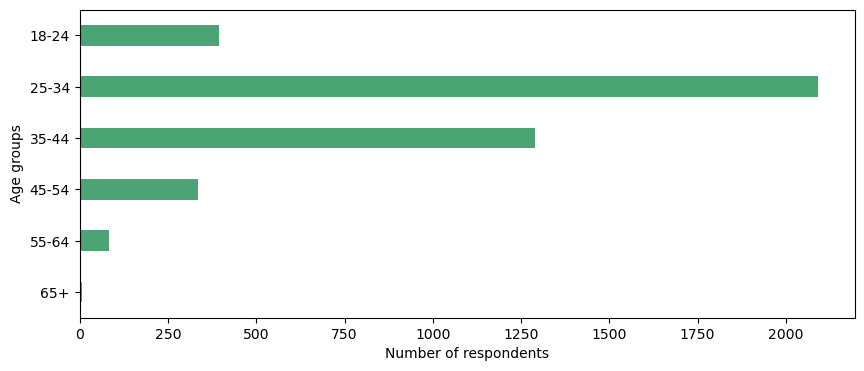

In [13]:
age_col = pivot_df['age']
age_bins = [17, 24, 34, 44, 54, 64, 70]
labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']

pivot_df['age_grouped'] = pd.cut(age_col, age_bins, labels=labels, right=True)
age_counts = pivot_df['age_grouped'].value_counts().reindex(labels)
plt.figure(figsize=(10, 4))
sns.barplot(y=age_counts.index, x=age_counts.values, order=labels, color="mediumseagreen", width=0.4)
plt.xlabel('Number of respondents')
plt.ylabel('Age groups')
plt.show();

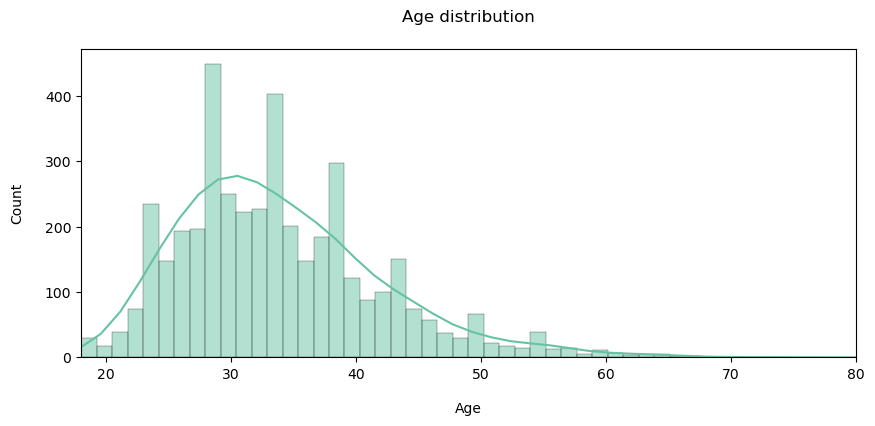

In [63]:
plt.figure(figsize=(10, 4))
age_plot = sns.histplot(pivot_df['age'], kde=True)
age_plot.set_xlim(18, 80)
age_plot.set_title('Age distribution', pad=20)
age_plot.set_xlabel('Age', labelpad=15)
age_plot.set_ylabel('Count', labelpad=15);

In [15]:
# Counting metrics of location

# Mean

mean_age = pivot_df['age'].mean().round(2)

# Median

median_age = pivot_df['age'].quantile(0.5)

# Mode

mode_age = pivot_df['age'].value_counts().head(1)

print('Metrics of location (age): ')
print('\n')
print(f'Mean: {mean_age}')
print(f'Median: {median_age}')
print('\n')
print(f'Mode:')
print(f'{mode_age}')


Metrics of location (age): 


Mean: 34.01
Median: 33.0


Mode:
age
30    250
Name: count, dtype: int64


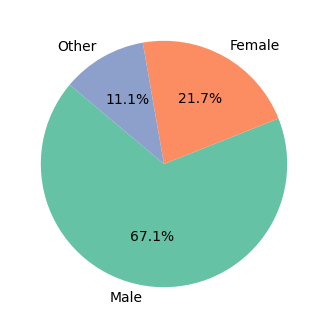

In [16]:
gender_counts = pivot_df['gender'].value_counts(normalize=True) * 100
plt.figure(figsize=(4, 4))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140)
plt.show()

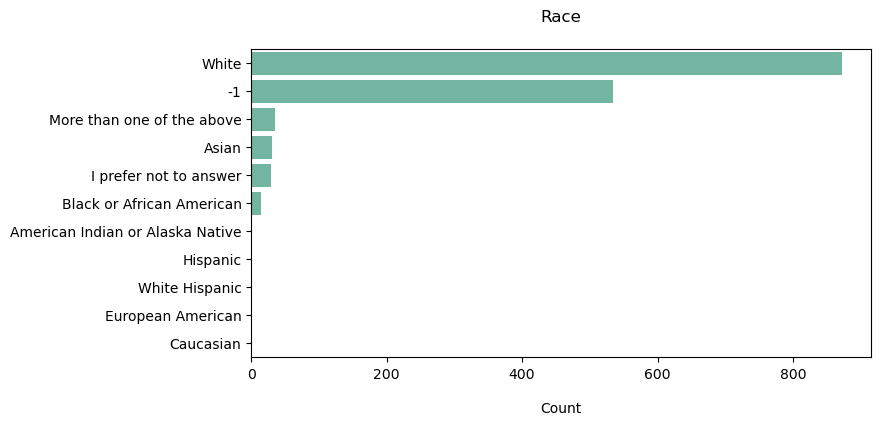

In [64]:
plt.figure(figsize=(8, 4))
sns.countplot(data=pivot_df, y='race', orient='h', order=pivot_df['race'].value_counts().index)
plt.title('Race', pad=20)
plt.ylabel('')
plt.xlabel('Count', labelpad=15);


### Overview

The data so far shows that the sample is biased:
- The majority of respondents represent the younger part of the population, with the greatest density at around 25-34 years old; metrics of location indicate, that the largest number of people are in their early 30s;
- The sample is dominated by males (67%); this, however, might represent the actual situation in the tech industry, where gender gap is still observed.
- The sample is racially homogenous and dominated by white respondents. However, we also see a great number of people who prefered not to state their race.
- However, if we analyze the age distribution per year per gender, we see that in smaller samples we get somewhat similar distributions in later years, but the overall sample is then skewed by the disproportions in years 2014 and 2016. We might modestly hypothesize about changing proportions of women in tech, however, the data is not sufficient to confirm it.

Further, we'll explore some descriptive statistics on location, companies and employment.

In [18]:
# Fixing the 'United States' ambiguity

countries = pivot_df.loc[pivot_df['country'].str.contains('United')]
countries['country'].value_counts()

# No US or USA entries, only United States and United States of America
# Converting to United States

pivot_df['country'] = pivot_df['country'].replace(to_replace='United States of America', value='United States')
countries = pivot_df.loc[pivot_df['country'].str.contains('United')]
countries['country'].value_counts()

country
United States     2599
United Kingdom     481
Name: count, dtype: int64

In [19]:
from sklearn.preprocessing import normalize

country_counts = pivot_df['country'].value_counts()
pivot_df['country_counts'] = pivot_df['country'].map(lambda x: 1 if country_counts[x] > 1 else 0)
print('The majority of countries are mentioned at least twice:', '\n', pivot_df['country_counts'].value_counts(normalize=True) * 100,
      '\n',
      '\n',
      'The most popular countries are:', '\n',
      pivot_df['country'].value_counts().head())

The majority of countries are mentioned at least twice: 
 country_counts
1    99.548157
0     0.451843
Name: proportion, dtype: float64 
 
 The most popular countries are: 
 country
United States     2599
United Kingdom     481
Canada             197
Germany            136
Netherlands         98
Name: count, dtype: int64


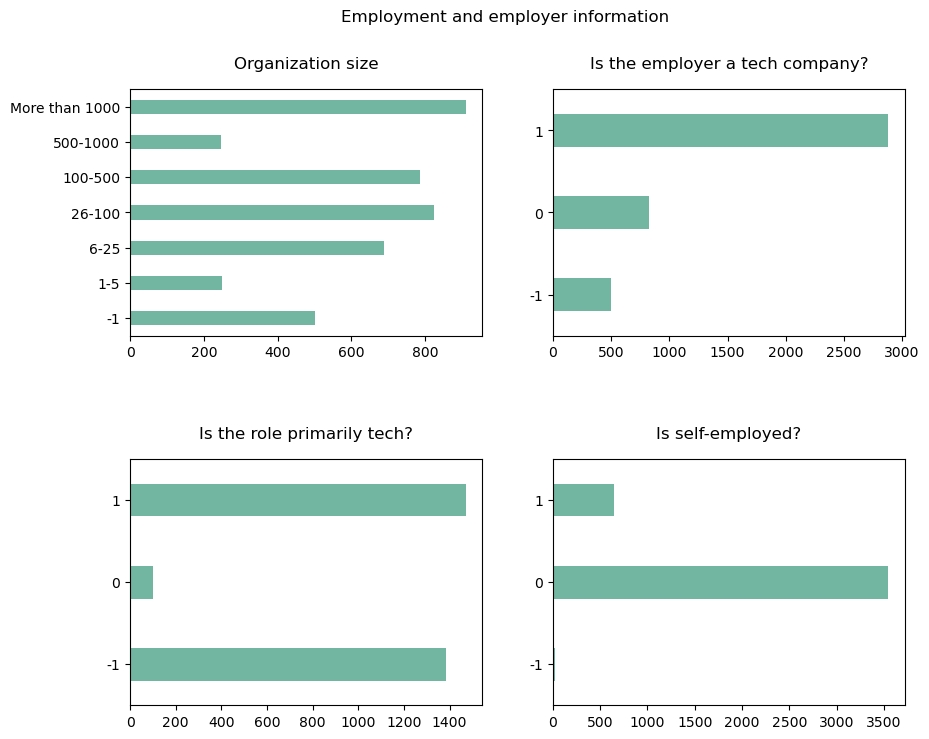

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('Employment and employer information')

## org_size
org_size_counts = pivot_df['org_size'].value_counts().reset_index()
org_size_counts.columns = ['org_size', 'count']
size_order = ['More than 1000', '500-1000', '100-500', '26-100', '6-25', '1-5', '-1']
sns.barplot(x='count', y='org_size', data=org_size_counts, ax=axs[0, 0], width=0.4, order=size_order)
axs[0, 0].set_title('Organization size', pad=15)
axs[0, 0].set(ylabel=None)
axs[0, 0].set(xlabel=None)

## employer_is_tech

employer_is_tech = pivot_df['employer_is_tech']
sns.countplot(data=employer_is_tech, ax=axs[0, 1], width=0.4)
axs[0, 1].set_title('Is the employer a tech company?', pad=15)
axs[0, 1].set(ylabel=None)
axs[0, 1].set(xlabel=None)

## role_primary_tech (NB: only 2016-2019 surveys!)

df_2014_excluded = pivot_df.loc[pivot_df['year'] != 2014]
role_primary_tech = df_2014_excluded['role_primary_tech']
a_order = ['1', '0', '-1']
sns.countplot(data=role_primary_tech, ax=axs[1, 0], width=0.4, order=a_order)
axs[1, 0].set_title('Is the role primarily tech?', pad=15)
axs[1, 0].set(ylabel=None)
axs[1, 0].set(xlabel=None)

## self_employed

self_employed = pivot_df['is_self_employed']
a_order = ['1', '0', '-1']
sns.countplot(data=self_employed, ax=axs[1, 1], width=0.4, order=a_order)
axs[1, 1].set_title('Is self-employed?', pad=15)
axs[1, 1].set(ylabel=None)
axs[1, 1].set(xlabel=None)

fig.subplots_adjust(hspace=0.5)


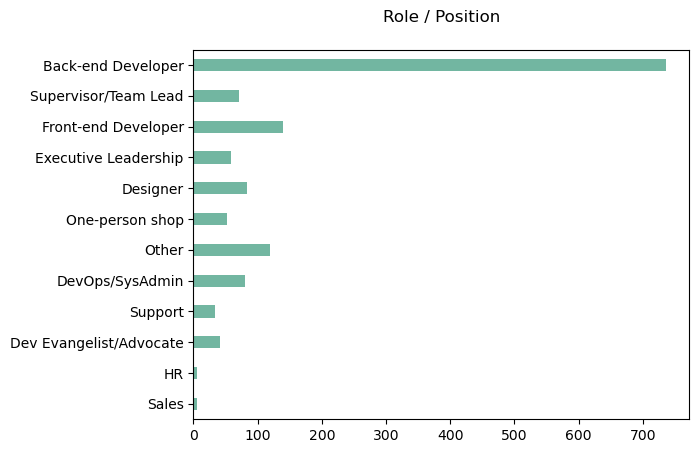

In [65]:
## What is the role of the respondent? (NB: only 2016 answers)

df_2016_only = pivot_df.loc[pivot_df['year'] == 2016]
role_of_respondent = df_2016_only['work_position']
role_plot = sns.countplot(data=role_of_respondent, width=0.4)
role_plot.set_title('Role / Position', pad=20)
role_plot.set(ylabel=None)
role_plot.set(xlabel=None);


### Overview

The analysis of the employers and employment status shows that the majority of data comes from the technology companies and people working in primarily tech roles. The companies they represent are either large (1000+ employee) corporates, or small-to-mid-sized enterprises. Companies of sizes 1-5 and 500-1000 are underrepresented. 

We should also notice that the 2016 year dataset is highly biased in terms of employee roles, with back-ender individual contributors making up the majority of the sample. This means that other roles of individual contributors and leadership are underrepresented. 

## 03 Exploratory data analysis



Now, let's explore some of the questions related to workplace mental health culture and personal medical history to better understand how various factors shape willingness to speak up about mental health issues and how they affect productivity and relationship with close relatives, co-workers and supervisors. As most of these questions are only covered in surveys from 2016-2019, it is sound to limit the scope of the dataset and focus our analysis on this subset.

Some initial questions to explore / hypotheses to test:

1. People are more willing to share about their mental disease / condition with close relatives rather than co-workers and supervisor; features: `comfortable_discuss_coworkers`, `comfortable_dicuss_supervisor`, `willing_to_share_close`.
2. The health benefits employer provides reduces the negative impact on productivity that mental disease can cause; features: `employer_benefits_provided`, `productivity_affected`, `percentage_prod_affected`.
3. Treated diseases interfere with the regular work less on average than untreated ones; features: `how_often_interferes_work_treated`, `how_ofter_interferes_untreated`.
4. The prevalence of mental health disease is higher with those whose family members were diagnosed with it previously; features: `if_family_mental_disorder`, `has_been_diagnosed`.
5. Those who are more aware about the mental health are less likely to be put off by seeing negative examples of how others with mental dieases are treated; fetures: `less_likely_to_share_obs_of_others`, `knows_resources`

Some of the questions are only covered in surveys from 2017-2019, so to answer the following, we'll limit our data once more:

6. Medical security has a positive impact on how the career is affected having a mental disease; features: `if_has_medical_cov`, `how_career_affected`
7. Lack of awareness about workplace benefits for mentally ill people leads to negative outlook on tech industry as a whole; features: `knowledge_of_benefits_available`, `thinks_tech_supports_employees`.

Finally, for the last set of explorations, we'll limit ourselves to the most informative 2016 subset of the survey:

8. Remote work affects the prevalence of mental disorder; feature: `has_mental_d_currently`, `works_remotely`
9. The prevalence of at least three mental diseases, as per the project requirements. These will be separately covered in the last part of this project, so we'll skip them in the EDA.

In [23]:
## Subsets of data based on year for further analysis

df_2016_2019 = pivot_df.loc[pivot_df['year'] != 2014]
df_2017_2019 = df_2016_2019.loc[pivot_df['year'] != 2016]
df_2016 = pivot_df.loc[pivot_df['year'] == 2016]

### 1. People are more willing to share about their mental disease / condition with close relatives rather than co-workers and supervisor
Features to use: `comfortable_discuss_co-workers`, `comfortable_dicuss_supervisor`, `willing_to_share_close`


In [24]:
# create the df with only three features: 

df_sharing = df_2016_2019[['comfortable_discuss_coworkers', 'comfortable_dicuss_supervisor', 'willing_to_share_close']]

# exclude NaN (-1)

df_sharing = df_sharing[df_sharing.comfortable_discuss_coworkers != '-1']
df_sharing = df_sharing[df_sharing.comfortable_dicuss_supervisor != '-1']
df_sharing = df_sharing[df_sharing.willing_to_share_close != 'Not applicable to me (I do not have a mental illness)']

# get dummies

df_sharing = pd.get_dummies(df_sharing, dtype=int)
df_sharing['workplace_discuss'] = df_sharing[['comfortable_discuss_coworkers_Yes', 'comfortable_dicuss_supervisor_Yes']].sum(axis=1)
df_sharing['workplace_discuss'] = df_sharing['workplace_discuss'].replace(to_replace=2, value=1)
df_sharing['acquaintance_discuss'] = df_sharing[['willing_to_share_close_Very open', 'willing_to_share_close_Somewhat open']].sum(axis=1)
df_sharing = df_sharing[['workplace_discuss', 'acquaintance_discuss']]


In [25]:
mean1 = df_sharing['workplace_discuss'].mean()
mean2 = df_sharing['acquaintance_discuss'].mean()
print(f'Workplace: {mean1}')
print(f'Relatives: {mean2}')

Workplace: 0.46010975094976786
Relatives: 0.6656817222456732


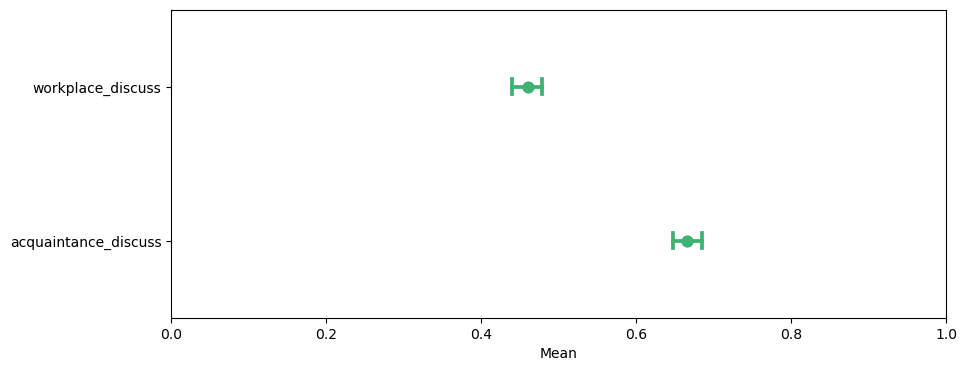

In [26]:
plt.figure(figsize=(10, 4))
sns.pointplot(
    data=df_sharing,
    errorbar=("ci", 95), capsize=.1,
    color="mediumseagreen", linestyle="none", orient='h'
)
plt.xlabel('Mean')
plt.xlim(0, 1)
plt.show()

In [27]:
import statsmodels.stats.api as sms

workplace_ci = sms.DescrStatsW(df_sharing['workplace_discuss']).tconfint_mean()
acquaintance_ci = sms.DescrStatsW(df_sharing['acquaintance_discuss']).tconfint_mean()

print("Willingness to discuss mental health in workplace: ")
print(f'Mean: {mean1.round(3)}')
print(f'Conf. interval low: {workplace_ci[0].round(4)}')
print(f'Conf. interval high: {workplace_ci[1].round(4)}')
print('\n')
print("Willingness to discuss mental health with acquaintances: ")
print(f'Mean: {mean2.round(3)}')
print(f'Conf. interval low: {acquaintance_ci[0].round(3)}')
print(f'Conf. interval high: {acquaintance_ci[1].round(3)}')

Willingness to discuss mental health in workplace: 
Mean: 0.46
Conf. interval low: 0.44
Conf. interval high: 0.4802


Willingness to discuss mental health with acquaintances: 
Mean: 0.666
Conf. interval low: 0.647
Conf. interval high: 0.685


The graph shows that we might conclude that sharing concerns about mental health is more common with acquaintances and close relatives rather than colleagues or supervisors. It seems that people are less likely to share their personal details in professional settings, meaning that if we were to develop AI-driven feature in productivity app it might not be a good idea.

### 2. The health benefits employer provides reduces the negative impact on productivity that mental disease can cause

Features to use: `employer_benefits_provided`, `productivity_affected`, `percentage_prod_affected`.

In [70]:
# create the df with only three features: 

df_benefits = df_2016_2019[['employer_benefits_provided', 'productivity_affected', 'percentage_prod_affected']]
# exclude NaN (-1)
df_benefits = df_benefits[(df_benefits.employer_benefits_provided != '-1') & (df_benefits.employer_benefits_provided != 'Not eligible for coverage / NA')]
df_benefits.loc[df_benefits['percentage_prod_affected'] != '-1']


,employer_benefits_provided,productivity_affected,percentage_prod_affected


It's interesting that if we remove people who chose not to answer the question about the benefits or said that they're not eligible for them, we also get no answers on productivity. Let's try to include them.

In [71]:
df_benefits = df_2016_2019[['employer_benefits_provided', 'productivity_affected', 'percentage_prod_affected']]
df_benefits = df_benefits.loc[df_benefits['percentage_prod_affected'] != '-1']
df_benefits['employer_benefits_provided'].value_counts()

employer_benefits_provided
-1    366
Name: count, dtype: int64

All of the the respondents, who had their productivity affected by mental disease, didn't disclose about the workplace benefits they received. It means we're at the dead-end here and must conclude that there's no sufficient data for exploration. Not to disappoint the reader, we at least leave the bar plot, reflecting the distribution of how productivity is affected. We'll convert categories to numerical 1-4 to simulate continuity of data. It's not very insightful yet, but it shows that the impact is not severe – for majority, it impacts up to a quarter of their capacity, and most values fall within 50%. We must also account that the data comes from survey were evaluations are arbitrary.

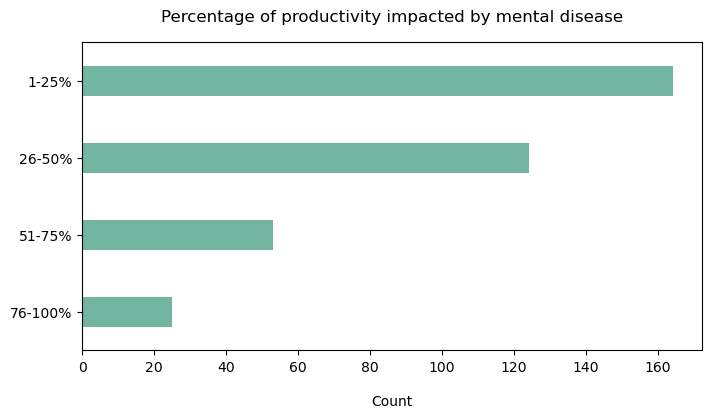

In [73]:
order = ['1-25%', '26-50%', '51-75%', '76-100%']
plt.figure(figsize=(8, 4))
prod_plt = sns.countplot(data = df_benefits, y='percentage_prod_affected', orient='h', order=order, width=0.4)
prod_plt.set_ylabel('')
prod_plt.set_xlabel('Count', labelpad=15)
prod_plt.set_title('Percentage of productivity impacted by mental disease', pad=15);

### 3. Treated diseases interfere with the regular work less on average than untreated ones 

Features to use: `how_often_interferes_work_treated`, `how_ofter_interferes_untreated`.

In [31]:
# create the df with only two features: 

df_interference = df_2016_2019[['how_often_interferes_work_treated', 'how_ofter_interferes_untreated']]

# remove not-applicables

df_interference = df_interference.loc[df_interference['how_often_interferes_work_treated'] != 'Not applicable to me']
df_interference = df_interference.loc[df_interference['how_ofter_interferes_untreated'] != 'Not applicable to me']

# convert categories to int values

old_values = ['Never', 'Rarely', 'Sometimes', 'Often']
new_values = [0, 1, 2, 3]
df_interference = df_interference.replace(old_values, new_values)
df_interference.head()


/var/folders/7j/0j88jv2s5njcjv6hwgj4j51w0000gn/T/ipykernel_13534/2485587150.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_interference = df_interference.replace(old_values, new_values)


,how_often_interferes_work_treated,how_ofter_interferes_untreated
1261,1,2
1263,2,2
1264,2,2
1267,2,3
1268,1,3


In the following cells, we calculate the distribution of how severely mental disease affects the routines of the people. Based on this information, we calculate the means, based on whether the disease is treated or not.

In [32]:
# Distribution of interference if disease is treated
df_interference['how_often_interferes_work_treated'].value_counts(normalize=True)

how_often_interferes_work_treated
2    0.439310
1    0.379733
3    0.091314
0    0.089644
Name: proportion, dtype: float64

In [33]:
# Distribution of interference if disease is untreated
df_interference['how_ofter_interferes_untreated'].value_counts(normalize=True)

how_ofter_interferes_untreated
3    0.616370
2    0.315145
1    0.056793
0    0.011693
Name: proportion, dtype: float64

In [34]:
# Calculating means
mean1 = df_interference['how_often_interferes_work_treated'].mean()
mean2 = df_interference['how_ofter_interferes_untreated'].mean()

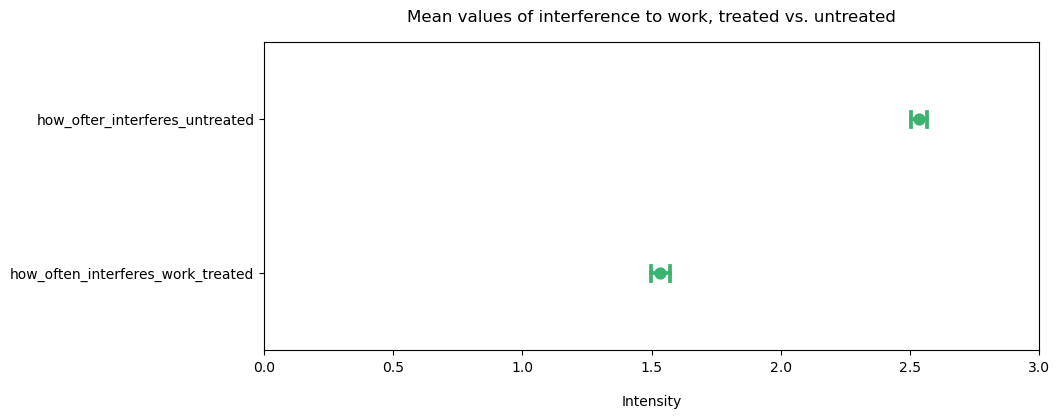

In [35]:
# converting to long format 
df_melted = pd.melt(df_interference, value_vars=['how_ofter_interferes_untreated', 'how_often_interferes_work_treated'], var_name='treatment', value_name='mean')

plt.figure(figsize=(10, 4))
sns.pointplot(
    data=df_melted, x='mean', y='treatment',
    errorbar=("ci", 95), capsize=.1,
    color="mediumseagreen", linestyle="none", orient='h'
)
plt.xlabel('Intensity', labelpad=15)
plt.xlim(0, 3)
plt.ylabel('')
plt.title('Mean values of interference to work, treated vs. untreated', pad=15)
plt.show()


In [36]:
import statsmodels.stats.api as sms

treated_mean = df_interference['how_often_interferes_work_treated'].mean()
untreated_mean = df_interference['how_ofter_interferes_untreated'].mean()

treated_ci = sms.DescrStatsW(df_interference['how_often_interferes_work_treated']).tconfint_mean()
untreated_ci = sms.DescrStatsW(df_interference['how_ofter_interferes_untreated']).tconfint_mean()

print("Interference in work, when mental health disease is treated: ")
print(f'Mean: {treated_mean.round(3)}')
print(f'Conf. interval low: {treated_ci[0].round(4)}')
print(f'Conf. interval high: {treated_ci[1].round(4)}')
print('\n')
print("Interference in work, when mental health disease is untreated: ")
print(f'Mean: {untreated_mean.round(3)}')
print(f'Conf. interval low: {untreated_ci[0].round(3)}')
print(f'Conf. interval high: {untreated_ci[1].round(3)}')

Interference in work, when mental health disease is treated: 
Mean: 1.532
Conf. interval low: 1.4961
Conf. interval high: 1.5685


Interference in work, when mental health disease is untreated: 
Mean: 2.536
Conf. interval low: 2.506
Conf. interval high: 2.567


This observation can be concluded with insight that untreated mental diseases tend to interfere with working routines more than untreated ones. 

### 4. The prevalence of mental health disease is higher with those whose family members were diagnosed with it previously
Features to use: `if_family_mental_disorder`, `has_been_diagnosed`.

In [37]:
# limit the dataframe to two cols

df_family = df_2016_2019[['if_family_mental_disorder', 'has_been_diagnosed']]

# remove -1 from has_been_diagnosed (NA / prefer not to say)

df_family = df_family.loc[df_family['has_been_diagnosed'] != '-1']

# remove 'I don't know' from if_family_mental_disorder

df_family = df_family.loc[df_family['if_family_mental_disorder'] != "I don't know"]

# get dummies

family_dummies = pd.get_dummies(df_family, dtype=int)
family_dummies[['family', 'self']] = family_dummies[['if_family_mental_disorder_Yes','has_been_diagnosed_Yes']]
family_dummies = family_dummies[['family', 'self']]

# run correlation

family_mean = family_dummies['family'].mean()
self_mean = family_dummies['self'].mean()

family_ci = sms.DescrStatsW(family_dummies['family']).tconfint_mean()
self_ci = sms.DescrStatsW(family_dummies['self']).tconfint_mean()

print("Mental disease diagnosed in family: ")
print(f'Mean: {family_mean.round(3)}')
print(f'Conf. interval low: {family_ci[0].round(4)}')
print(f'Conf. interval high: {family_ci[1].round(4)}')
print('\n')
print("Mental disease diagnosed for oneself: ")
print(f'Mean: {self_mean.round(3)}')
print(f'Conf. interval low: {self_ci[0].round(3)}')
print(f'Conf. interval high: {self_ci[1].round(3)}')
print('\n')
print(f'Correlation between the two features: ')
print(f'{(family_dummies["family"].corr(family_dummies["self"], method="spearman")).round(2)}')

Mental disease diagnosed in family: 
Mean: 0.659
Conf. interval low: 0.6366
Conf. interval high: 0.6823


Mental disease diagnosed for oneself: 
Mean: 0.654
Conf. interval low: 0.631
Conf. interval high: 0.677


Correlation between the two features: 
0.45


These results show somewhat a moderate correlation between mental disease diagnosis in family and previous diagnosis of oneself. 

### 5. Those who are more aware about the mental health are less likely to be put off by seeing negative examples of how others with mental dieases are treated
Features to use: `less_likely_to_share_obs_of_others`, `knows_resources`

As the features are not as informative here, here's the full question texts:

_Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?_

_Do you know local or online resources to seek help for a mental health issue?_

We make the assumption that knowledge on local or online resources indicate the awareness about the mental health as it shows one's willingness to dig into the problem and look for answers, oftne leading to rejection of misconceptions and stereotypes. 

In [38]:
# limit the dataframe to two cols

df_awareness = df_2016_2019[['less_likely_to_share_obs_of_others', 'knows_resources']]

# remove -1 from knows_resources (NA / prefer not to say)

df_awareness = df_awareness.loc[df_awareness['knows_resources'] != '-1']

# remove 'I don't know' from less_likely_to_share_obs_of_others, also the 'Maybe' value

df_awareness = df_awareness.loc[df_awareness['less_likely_to_share_obs_of_others'] != '-1']
df_awareness = df_awareness.loc[df_awareness['less_likely_to_share_obs_of_others'] != 'Maybe']

# get dummies

awareness_dummies = pd.get_dummies(df_awareness, dtype=int)
awareness_dummies['resource_knowledge'] = awareness_dummies[['knows_resources_I know some', 'knows_resources_Yes, I know several']].sum(axis=1)
awareness_dummies['sharing'] = awareness_dummies['less_likely_to_share_obs_of_others_No']
awareness_dummies = awareness_dummies[['resource_knowledge', 'sharing']]

# run correlation

resource_mean = awareness_dummies['resource_knowledge'].mean()
sharing_mean = awareness_dummies['sharing'].mean()

resource_ci = sms.DescrStatsW(awareness_dummies['resource_knowledge']).tconfint_mean()
sharing_ci = sms.DescrStatsW(awareness_dummies['sharing']).tconfint_mean()

print("Resource knowledge: ")
print(f'Mean: {resource_mean.round(3)}')
print(f'Conf. interval low: {resource_ci[0].round(4)}')
print(f'Conf. interval high: {resource_ci[1].round(4)}')
print('\n')
print("Not put off by examples of colleagues: ")
print(f'Mean: {sharing_mean.round(3)}')
print(f'Conf. interval low: {sharing_ci[0].round(3)}')
print(f'Conf. interval high: {sharing_ci[1].round(3)}')
print('\n')
print(f'Correlation between the two features: ')
print(f'{(awareness_dummies["resource_knowledge"].corr(awareness_dummies["sharing"], method="spearman")).round(2)}')

Resource knowledge: 
Mean: 0.769
Conf. interval low: 0.7117
Conf. interval high: 0.8261


Not put off by examples of colleagues: 
Mean: 0.505
Conf. interval low: 0.437
Conf. interval high: 0.573


Correlation between the two features: 
-0.01


From these results we see that that only minimal negative correlation exists and it doesn't allow us to make any finite conclusions that knowledge of resources (and implied awareness) somehow influences the willingness to ignore previous negative experiences of colleagues speaking up about their mental health issues. It is possible that these factors are more related to either personality traits (e.g., fighting for the right cause, persistence, courage) or workplace culture (e.g., employee empowerment, awareness raising, encouragement, support, etc.)

### 6. Medical security has a positive impact on how the career is affected having a mental disease
Features to use: `if_has_medical_cov`, `how_career_affected`

In [39]:
df_career = df_2017_2019[['if_has_medical_cov', 'how_career_affected']]

df_career = df_career.loc[df_career['if_has_medical_cov'] != '-1']
df_career = df_career.loc[df_career['how_career_affected'] != '-1']

Both questions have very large Null value rate, meaning that the eventual sample of effects on career and possesionf of medical coverage is too small to draw any meaningful conclusions. Given this, we might look for alternative approaches to explore. 

In [40]:
df_career = df_2017_2019[['if_has_medical_cov', 'percentage_prod_affected']]
df_career = df_career[(df_career.if_has_medical_cov != '-1') & (df_career.percentage_prod_affected != '-1')]

Text(0.5, 1.0, 'Percentage of productivity impacted by mental disease')

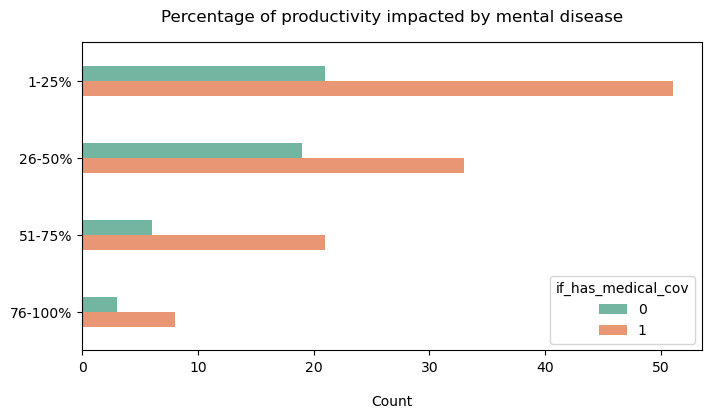

In [41]:
order = ['1-25%', '26-50%', '51-75%', '76-100%']
plt.figure(figsize=(8, 4))
prod_plt = sns.countplot(data = df_career, y='percentage_prod_affected', orient='h', order=order, width=0.4, hue='if_has_medical_cov')
prod_plt.set_ylabel('')
prod_plt.set_xlabel('Count', labelpad=15)
prod_plt.set_title('Percentage of productivity impacted by mental disease', pad=15)

In [42]:
# convert productivity categories to int values

old_values = ['1-25%', '26-50%', '51-75%', '76-100%']
new_values = [1, 2, 3, 4]
df_productivity = df_career.replace(old_values, new_values)

# see the correlation of medical coverage and productivity

print(f'The correlation between productivity affected and possesion of medical coverage: ')
print(f"{df_productivity['if_has_medical_cov'].corr(df_productivity['percentage_prod_affected'], method='spearman')}")


The correlation between productivity affected and possesion of medical coverage: 
0.017365329023966144


/var/folders/7j/0j88jv2s5njcjv6hwgj4j51w0000gn/T/ipykernel_13534/2381523724.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_productivity = df_career.replace(old_values, new_values)


Given these results, we can indicate that the effect on owning the medical coverage is weak on how the productivity is affected. It is also evident in the bar chart, where productivity is affected somewhat the same, only that more people have medical coverage than not.

### 7. Lack of awareness about workplace benefits for mentally ill people leads to negative outlook on tech industry as a whole
Features to use: `knowledge_of_benefits_available`, `thinks_tech_supports_employees`.

In [43]:
df_tech_support = df_2017_2019[['knowledge_of_benefits_available', 'thinks_tech_supports_employees']]
df_tech_support = df_tech_support.astype({"thinks_tech_supports_employees": int, "knowledge_of_benefits_available": object})
df_tech_support = df_tech_support[df_tech_support.knowledge_of_benefits_available != '-1'] 
df_tech_support = df_tech_support.replace(to_replace=['Yes', 'No'], value=[1, 0])


/var/folders/7j/0j88jv2s5njcjv6hwgj4j51w0000gn/T/ipykernel_13534/875656356.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_tech_support = df_tech_support.replace(to_replace=['Yes', 'No'], value=[1, 0])


In [44]:
df_tech_support['knowledge_of_benefits_available'].value_counts()

knowledge_of_benefits_available
0    615
1    562
Name: count, dtype: int64

In [45]:
df_tech_support['thinks_tech_supports_employees'].value_counts()

thinks_tech_supports_employees
3    477
2    371
4    163
1    152
5     14
Name: count, dtype: int64

In [46]:
df_tech_support.corr(method='spearman')

,knowledge_of_benefits_available,thinks_tech_supports_employees
knowledge_of_benefits_available,1.000000,0.057582
thinks_tech_supports_employees,0.057582,1.000000


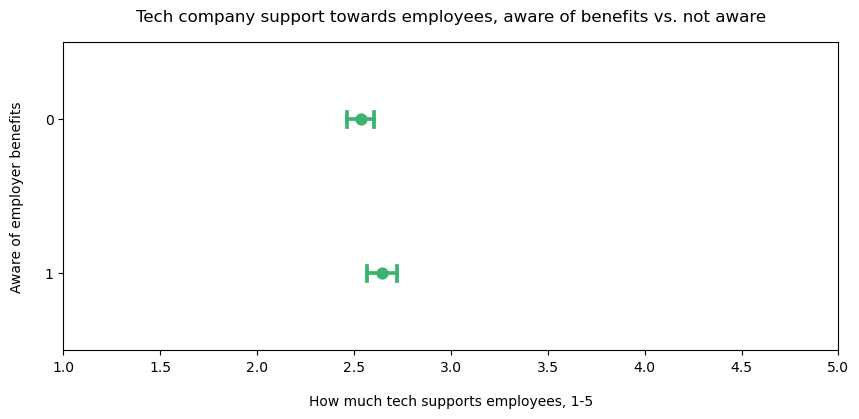

In [47]:
plt.figure(figsize=(10, 4))
sns.pointplot(
    data=df_tech_support, x='thinks_tech_supports_employees', y='knowledge_of_benefits_available',
    errorbar=("ci", 95), capsize=.1,
    color="mediumseagreen", linestyle="none", orient='h'
)
plt.xlabel('How much tech supports employees, 1-5', labelpad=15)
plt.xlim(1, 5)
plt.ylabel('Aware of employer benefits', labelpad=15)
plt.title('Tech company support towards employees, aware of benefits vs. not aware', pad=15)
plt.show()

Again, we see no strong correlation between two variables. This further strenghtens our intuition that  workplace culture is somewhat insufficient to reveal people's perception on mental health and its issues or treatment. That doesn't prove that employers shouldn't invest in employees support, yet it is vital to understand that the complexity of the issue transcends the workplace and maintaining the work-life balance is crucial.

### 8. Remote work affects the prevalence of mental disorder
Features to use: `has_mental_d_currently`, `works_remotely`

In [48]:
df_remote = df_2016[['has_mental_d_currently', 'works_remotely']]
df_remote.head()

,has_mental_d_currently,works_remotely
1260,No,Sometimes
1261,Yes,Never
1262,No,Always
1263,Yes,Sometimes
1264,Yes,Sometimes


In [49]:
df_remote['has_mental_d_currently'].value_counts()

has_mental_d_currently
Yes      575
No       529
Maybe    326
Name: count, dtype: int64

In [50]:
df_remote['works_remotely'].value_counts()

works_remotely
Sometimes    755
Always       342
Never        333
Name: count, dtype: int64

In [51]:
df_remote.apply(lambda x: x.factorize()[0]).corr()


,has_mental_d_currently,works_remotely
has_mental_d_currently,1.000000,0.056045
works_remotely,0.056045,1.000000


The factorized correlation shows no direct relationship between the variables. However, maybe we could perform similar operations with perceived rather than diagnosed mental diseases?

In [52]:
df_perceived = df_2016[['conditions_believes_has', 'works_remotely']]
df_perceived.apply(lambda x: x.factorize()[0]).corr()


,conditions_believes_has,works_remotely
conditions_believes_has,1.000000,-0.003381
works_remotely,-0.003381,1.000000


The negative correlation is even weaker. Let's clean the data a bit.

In [53]:
# convert categories to int values

old_values = ['Yes', 'No', 'Maybe', 'Sometimes', 'Always', 'Never']
new_values = [1, 0, 0, 0, 1, 0]
df_remote = df_remote.replace(old_values, new_values)
df_remote.corr()

/var/folders/7j/0j88jv2s5njcjv6hwgj4j51w0000gn/T/ipykernel_13534/531366614.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_remote = df_remote.replace(old_values, new_values)


,has_mental_d_currently,works_remotely
has_mental_d_currently,1.000000,-0.005074
works_remotely,-0.005074,1.000000


We can conclude that working remotely – at least, from this data, – doesn't show any relationship with potential deterioration of mental health. We now proceed to our latest part of the exploration, indicating the occurences of several mental diseases.

## 04 Attempt at inference: the prevalence of mental diseases

In the last section of our exploration, we aim to see the proportion of mental diseases in the sample and attempt to count the confidence interval, infering preliminary insights about the populations. Some things to be aware of here:
- dataset focuses on tech industry employees;
- dataset overrepresents males, even though this might be just the realities of the tech industry;
- dataset is dominated by back-enders;
- we only operate with data from 2016 here.

In [54]:
diagnosis = df_2016['conditions_diagnosed_with']
diagnosis.value_counts()

conditions_diagnosed_with
-1                                                                                                                                                           862
Anxiety Disorder (Generalized, Social, Phobia, etc)                                                                                                          319
Mood Disorder (Depression, Bipolar Disorder, etc)                                                                                                            114
Attention Deficit Hyperactivity Disorder                                                                                                                      56
Addictive Disorder                                                                                                                                            35
Post-traumatic Stress Disorder                                                                                                                                 8
Psychoti

Seeing this, let's focus our efforts on three most prevalent diseases. Those are:
- Anxiety Disorder (Generalized, Social, Phobia, etc);
- Mood Disorder (Depression, Bipolar Disorder, etc);
- Attention Deficit Hyperactivity Disorder

Proportionally, it looks like this:

In [55]:
series = diagnosis.value_counts().head(4)
normalized_series = diagnosis.value_counts(normalize=True).head(4) * 100
print('Count: ')
print(series.iloc[1:4])
print('\n')
print('Percentage: ')
print(normalized_series.iloc[1:4].round(2))
print('\n')
print(f'Full sample: {diagnosis.shape[0]}')

Count: 
conditions_diagnosed_with
Anxiety Disorder (Generalized, Social, Phobia, etc)    319
Mood Disorder (Depression, Bipolar Disorder, etc)      114
Attention Deficit Hyperactivity Disorder                56
Name: count, dtype: int64


Percentage: 
conditions_diagnosed_with
Anxiety Disorder (Generalized, Social, Phobia, etc)    22.31
Mood Disorder (Depression, Bipolar Disorder, etc)       7.97
Attention Deficit Hyperactivity Disorder                3.92
Name: proportion, dtype: float64


Full sample: 1430


In [74]:
from statsmodels.stats import proportion

anxiety = proportion.proportion_confint(series.iloc[1], nobs=diagnosis.shape[0])
mood = proportion.proportion_confint(series.iloc[2], nobs=diagnosis.shape[0])
adhd = proportion.proportion_confint(series.iloc[3], nobs=diagnosis.shape[0])

print(f'CI low and high value for anxiety: {anxiety}')
print(f'CI low and high value for mood disorders: {mood}')
print(f'CI low and high value for ADHD: {adhd}')

CI low and high value for anxiety: (0.2014996575574633, 0.24465418859638288)
CI low and high value for mood disorders: (0.06568166015671958, 0.09375889928383985)
CI low and high value for ADHD: (0.029107012003413514, 0.049214666318264814)


In [57]:
print("Anxiety distribution: ")
print(f'Proportion of sample: {normalized_series.iloc[1].round(3)}')
print(f'Conf. interval low: {anxiety[0] * 100}')
print(f'Conf. interval high: {anxiety[1] * 100}')
print('\n')
print("Mood disorder distribution: ")
print(f'Proportion of sample: {normalized_series.iloc[2].round(3)}')
print(f'Conf. interval low: {mood[0] * 100}')
print(f'Conf. interval high: {mood[1] * 100}')
print('\n')
print("ADHD distribution: ")
print(f'Proportion of sample: {normalized_series.iloc[3].round(3)}')
print(f'Conf. interval low: {adhd[0] * 100}')
print(f'Conf. interval high: {adhd[1] * 100}')

Anxiety distribution: 
Proportion of sample: 22.308
Conf. interval low: 20.14996575574633
Conf. interval high: 24.465418859638287


Mood disorder distribution: 
Proportion of sample: 7.972
Conf. interval low: 6.568166015671959
Conf. interval high: 9.375889928383984


ADHD distribution: 
Proportion of sample: 3.916
Conf. interval low: 2.9107012003413515
Conf. interval high: 4.9214666318264815


In [58]:
# converting diagnosis to dummy variables
diagnosis_freq = pd.get_dummies(pd.DataFrame(diagnosis), dtype=int)
diagnosis_freq = diagnosis_freq[['conditions_diagnosed_with_Anxiety Disorder (Generalized, Social, Phobia, etc)', 'conditions_diagnosed_with_Mood Disorder (Depression, Bipolar Disorder, etc)', 'conditions_diagnosed_with_Attention Deficit Hyperactivity Disorder']]
diagnosis_freq = diagnosis_freq.rename({
    'conditions_diagnosed_with_Anxiety Disorder (Generalized, Social, Phobia, etc)': 'Anxiety',
    'conditions_diagnosed_with_Mood Disorder (Depression, Bipolar Disorder, etc)': 'Mood',
    'conditions_diagnosed_with_Attention Deficit Hyperactivity Disorder': 'ADHD'
}, axis=1)

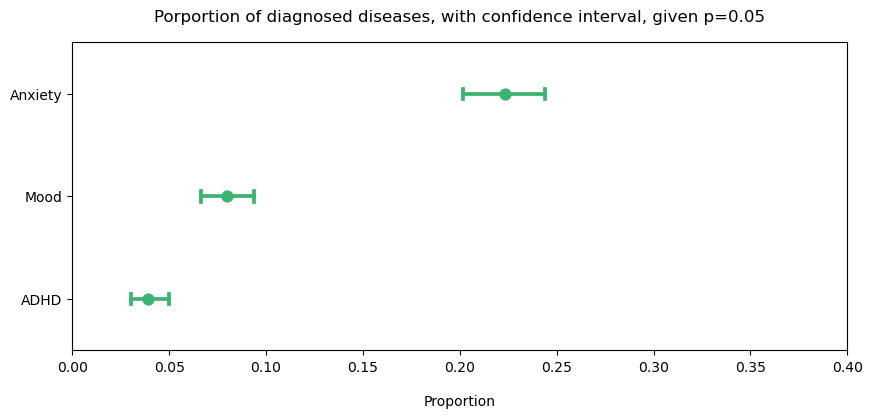

In [59]:
df_melted = pd.melt(diagnosis_freq, value_vars=['Anxiety', 'Mood', 'ADHD'], var_name='disorder', value_name='mean')

plt.figure(figsize=(10, 4))
sns.pointplot(
    data=df_melted, x='mean', y='disorder',
    errorbar=("ci", 95), capsize=.1,
    color="mediumseagreen", linestyle="none", orient='h'
)
plt.xlabel('Proportion', labelpad=15)
plt.xlim(0, 0.4)
plt.ylabel('')
plt.title('Porportion of diagnosed diseases, with confidence interval, given p=0.05', pad=15)
plt.show()


This tells us that while anxiety-related issues are most common, their confidence interval is also the largest and the most widespread. However, before making generalization about the general population, we should also take into account the aforementioned limitations of the dataset, given its biases and skewness. Also, remember that data here is not randomized and collected via open online survey. 

## 05 Summary

1. The data is made up of 5 different year surveys, with increasing/changing questions each year. The overall sample is biased as is it is collected without random selection and relies on participation of the respondents in the online survey.
2. The majority of respondents are male, with most of overall sample falling between 20 and 40 years of age. So we have a male-dominant sample of younger population, which _might_ reflect the state in the technology industry, but it has to confirmed with another probability sample. The majority of respondents come from the US. The leading role is back-end developer, with other positions underrepresented in the whole sample.
3. Data shows that people are more comfortable sharing about their mental health with relatives rather than colleagues or supervisors. 
4. If mental diseases affect the productivity, it mostly falls between 0-50%. However, this is a respondent-reported data rather than 'hard' observation-based insight.
4. The impact on work when the disease is treated vs. untreated shows the importance of workplace culture and mental health awareness. When the disease is addressed, it impacts the work relatively less than when left unattended. 
5. Mental health issues in family moderately correlates to diagnosis (0.45).
6. Medical security, knowledge about help resources, employee benefits do not seem to influence the personal perception about mental health, meaning that while workplace culture is important, it doesn't necessearily play the most important role in one's uderstanding of personal health.
7. Finally, from 2016 dataset we see than anxiety disorders, mood disorders and ADHD are the most popular diagnosed reported cases of mental health issues. We attempted to plot the distribution with confidence intervals.

### Areas of improvement

1. We deliberately selected limited scope of questions to analyze, leaving a somewhat larger chunk of data behind. To delve into the questions deeper, additional questions could be addressed – how changing employer influences the overall emotional and psychological wellbeing? how data evolves year-by-year? 
2. We could normalize data, using some socio-demographics as a leverage, to better reflect the population; however, we should still address the caveat of data _maybe_ reflecting the distribution of age and gender in tech industry.
3. We could introduce more questions related to employer's standing on the issue of mental health, to better understand growing or declining importance over the years. 
4. The analysis of open questions (decriptions) could also benefit us in raising more accurate, targetted hypotheses.